In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

#Load the dataset
data = pd.read_csv('/content/hour.csv')
print(data.head())

# Handle missing values if necessary
data.fillna(method='ffill', inplace=True)

# Convert 'weathersit' to categorical codes
data['weathersit'] = data['weathersit'].astype('category').cat.codes

# Rename columns to match the previous example
data.rename(columns={'weathersit': 'weather', 'temp': 'temperature'}, inplace=True)

# Extract relevant features
data['hour'] = data['hr']
data['day_of_week'] = data['weekday']

# Drop unnecessary columns
columns_to_drop = ['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'atemp', 'hum', 'windspeed', 'casual', 'registered']
data.drop(columns=columns_to_drop, inplace=True)

# Display the preprocessed data
print("After Processing:-")
print(data.head())

# Split the data into features and target
X = data.drop(columns=['cnt'])
y = data['cnt']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best parameters: {best_params}')

# Use the best model to make predictions
best_model = grid_search.best_estimator_

# Function to predict ride requests for a specific hour
def predict_ride_requests(hour, day_of_week, temperature, weather, model, feature_names):
    weather_code = pd.Series([weather]).astype('category').cat.codes[0]
    input_data = pd.DataFrame({
        'hour': [hour],
        'day_of_week': [day_of_week],
        'temperature': [temperature],
        'weather': [weather_code]
    })
    input_data = input_data[feature_names]
    # Predict ride requests
    prediction = model.predict(input_data)
    return round(prediction[0])
    input_data = input_data[feature_names]
    prediction = model.predict(input_data)
    return prediction[0]

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  
After Processing:-
   weather  temperature  cnt  hour  day_of_week
0        0         0.24   16    

In [45]:
# Ensure the feature order matches the training data
feature_names = X.columns.tolist()

# Example usage of the prediction function
hour = 17
day_of_week = 6
temperature = 0.44
weather = 1  # Clear weather

predicted_requests = predict_ride_requests(hour, day_of_week, temperature, weather, best_model, feature_names)
print(f'Predicted ride requests for {hour}:00 on day {day_of_week} with temperature {temperature*100}°C and weather {weather} : {predicted_requests}')

Predicted ride requests for 17:00 on day 6 with temperature 44.0°C and weather 1 : 277


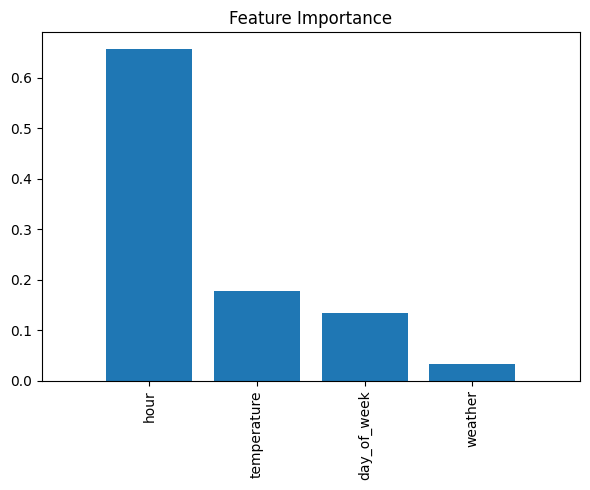

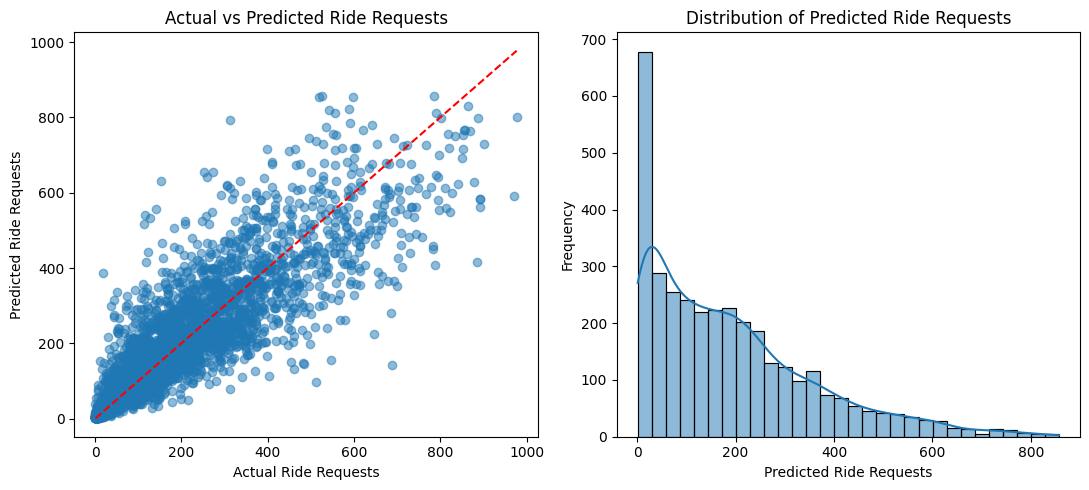

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Feature Importance
def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    indices = importances.argsort()[::-1]
    plt.figure(figsize=(6,5))
    plt.title("Feature Importance")
    plt.bar(range(len(feature_names)), importances[indices], align="center")
    plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=90)
    plt.xlim([-1, len(feature_names)])
    plt.tight_layout()
    plt.show()

plot_feature_importance(best_model, feature_names)

# Plot Predictions vs Actuals and Distribution of Predictions side-by-side
def plot_side_by_side(y_test, y_pred):
    fig, ax = plt.subplots(1, 2, figsize=(11,5))

    # Plot Predictions vs Actuals
    ax[0].scatter(y_test, y_pred, alpha=0.5)
    ax[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    ax[0].set_xlabel('Actual Ride Requests')
    ax[0].set_ylabel('Predicted Ride Requests')
    ax[0].set_title('Actual vs Predicted Ride Requests')

    # Plot Distribution of Predictions
    sns.histplot(y_pred, kde=True, bins=30, ax=ax[1])
    ax[1].set_xlabel('Predicted Ride Requests')
    ax[1].set_ylabel('Frequency')
    ax[1].set_title('Distribution of Predicted Ride Requests')

    plt.tight_layout()
    plt.show()

plot_side_by_side(y_test, y_pred)
